In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [3]:
from keras import backend as K
K.clear_session()

with tf.Session() as sess:
        sess = tf.Session()
        K.set_session(sess)

Using TensorFlow backend.


In [4]:
init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1559877053424827368, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9221160305
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9350370140378465084
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6683898676
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9722060264004199057
 physical_device_desc: "device: 1, name: GeForce GTX 1070 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [6]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from keras.applications.xception import Xception, preprocess_input
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [8]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train\AKIEC 3856
data/train\BCC 4773
data/train\BKL 3275
data/train\DF 4152
data/train\MEL 3308
data/train\NV 4975
data/train\VASC 3488


In [9]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation\AKIEC 1552
data/validation\BCC 1692
data/validation\BKL 1479
data/validation\DF 1632
data/validation\MEL 1664
data/validation\NV 1730
data/validation\VASC 1484


In [10]:
## Intilizing variables
output_classes = 7

batch_size = 64
epochs = 50
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

In [26]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (224, 224)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = True)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [12]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [16]:
model = Sequential()

## Architecture
model.add(Conv2D( filters = 96, kernel_size = (11,11), strides = 4, padding = 'same', activation = 'relu', 
                 input_shape = (224, 224, 3), kernel_initializer = 'he_normal'))
model.add(MaxPooling2D( pool_size = (3,3), strides = (2,2), padding= 'same', data_format = None)) # overlapping pooling

model.add(Conv2D( filters = 256, kernel_size = (5,5), strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D( pool_size = (3,3), strides = (2,2), padding= 'same', data_format = None)) 

model.add(Conv2D( filters = 384, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Conv2D( filters = 384, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Conv2D( filters = 256, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D( pool_size = (3,3), strides = (2,2), padding= 'same', data_format = None))

model.add(Flatten())
model.add(Dense( units = 4096, activation = 'relu'))
model.add(Dense( units = 4096, activation = 'relu'))

model.add(Dense( units = 7, activation = 'softmax'))
# model.summary()

## Optimizer
adam = optimizers.adam(lr=0.00005, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay= 0, amsgrad = False)
momentum = optimizers.SGD(lr=0.01, momentum = 0.9, decay=1e-6)

In [17]:
from keras import losses, metrics, regularizers
model.compile(optimizer = adam, loss='categorical_crossentropy',   metrics = ["categorical_accuracy", fmeasure, recall, precision])

In [18]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 482s 235ms/step - loss: 0.8862 - categorical_accuracy: 0.6582 - fmeasure: 0.6101 - recall: 0.5266 - precision: 0.7793 - val_loss: 0.9837 - val_categorical_accuracy: 0.6878 - val_fmeasure: 0.6785 - val_recall: 0.6279 - val_precision: 0.7401
Epoch 2/50
2048/2048 [==============================] - 442s 216ms/step - loss: 0.3303 - categorical_accuracy: 0.8744 - fmeasure: 0.8735 - recall: 0.8460 - precision: 0.9042 - val_loss: 1.0174 - val_categorical_accuracy: 0.7811 - val_fmeasure: 0.7796 - val_recall: 0.7593 - val_precision: 0.8017
Epoch 3/50
2048/2048 [==============================] - 442s 216ms/step - loss: 0.1609 - categorical_accuracy: 0.9396 - fmeasure: 0.9394 - recall: 0.9303 - precision: 0.9490 - val_loss: 1.0900 - val_categorical_accuracy: 0.7861 - val_fmeasure: 0.7878 - val_recall: 0.7731 - val_precision: 0.8035
Epoch 4/50
2048/2048 [==============================] - 442s 216ms/step - loss: 0.0817 - categorical_accuracy: 0

2048/2048 [==============================] - 443s 216ms/step - loss: 1.2140e-07 - categorical_accuracy: 1.0000 - fmeasure: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9786 - val_categorical_accuracy: 0.8124 - val_fmeasure: 0.8125 - val_recall: 0.8117 - val_precision: 0.8133
Epoch 29/50
2048/2048 [==============================] - 442s 216ms/step - loss: 1.1970e-07 - categorical_accuracy: 1.0000 - fmeasure: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9902 - val_categorical_accuracy: 0.8139 - val_fmeasure: 0.8137 - val_recall: 0.8130 - val_precision: 0.8144
Epoch 30/50
2048/2048 [==============================] - 442s 216ms/step - loss: 1.1928e-07 - categorical_accuracy: 1.0000 - fmeasure: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.0141 - val_categorical_accuracy: 0.8135 - val_fmeasure: 0.8132 - val_recall: 0.8125 - val_precision: 0.8140
Epoch 31/50
2048/2048 [==============================] - 442s 216ms/step - loss: 1.1922e-07 - categorical_acc

In [27]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  2.242692073583603
Test Accuracy:  0.804375
fmeasure:  0.8049106538295746
Recall:  0.804375
Precision:  0.8054637086391448


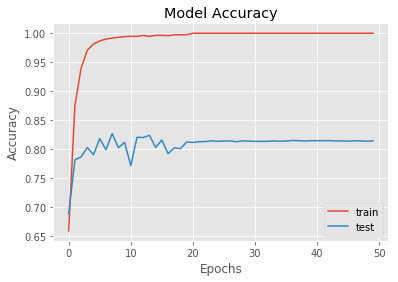

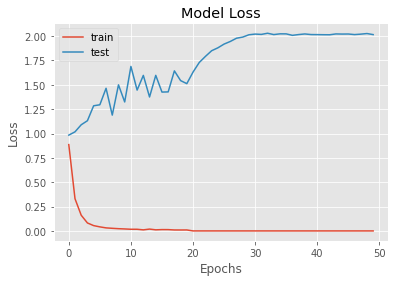

In [28]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

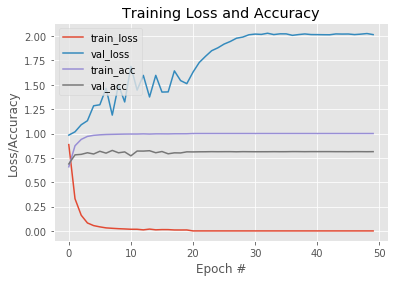

In [29]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [30]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (224, 224)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [31]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 49s 140ms/step
No of errors = 2092/11233


Confusion Matrix
[[1164   81  178   14   80   35    0]
 [  22 1491   68    3   42   39   27]
 [  25   20 1300    1   54   79    0]
 [  53  125   94 1236   31   86    7]
 [   6   12   80    0 1431  133    2]
 [   6   14   91   10  120 1484    5]
 [   0   23   50    1   42  333 1035]]


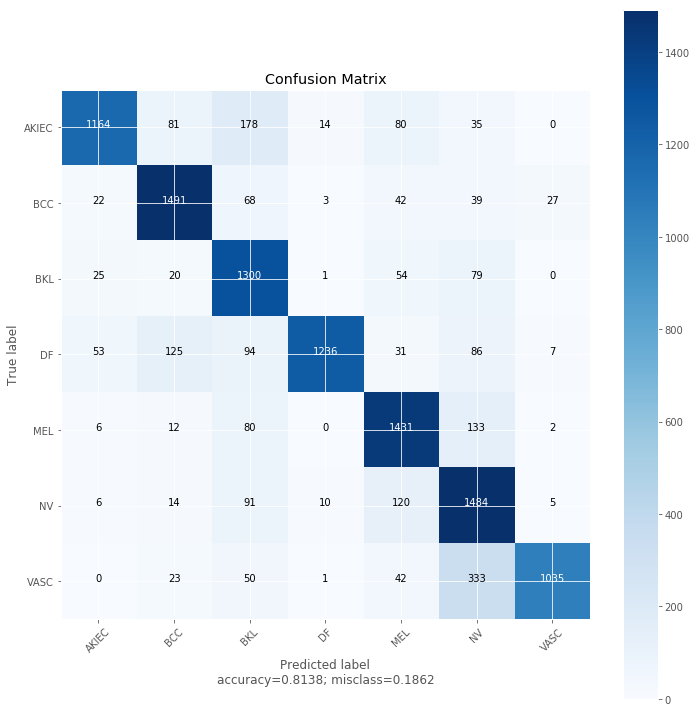

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/2.AlexNet-CM.png', bbox_inches='tight', dpi = 100)

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

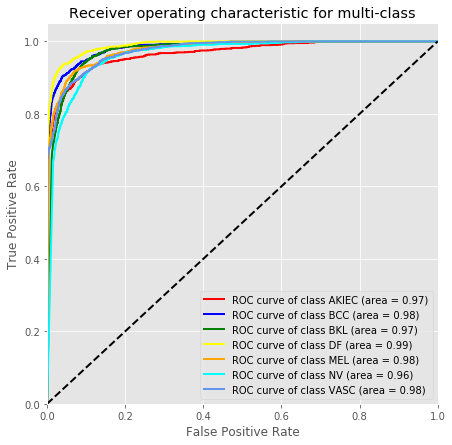

In [37]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle




y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = validation_generator.classes

classnames=[]
for classname in validation_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=7
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

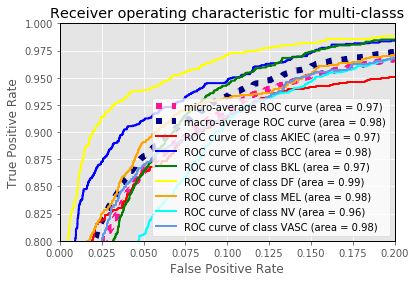

<Figure size 432x288 with 0 Axes>

In [72]:
# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=6)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=6)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
# plt.axis('off')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')


plt.rcParams['figure.facecolor'] = 'white'
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.savefig('plots/2.AlexNet-ROC.png', dpi = 100)
plt.show()

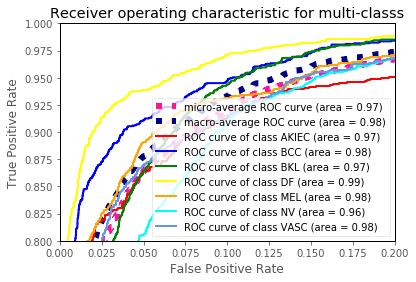

In [79]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=6)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=6)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")


legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')




plt.rcParams['axes.facecolor'] = 'white'


plt.savefig('plots/2.AlexNet-ROC.png', dpi = 100)
plt.show()

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1164   81  178   14   80   35    0]
 [  22 1491   68    3   42   39   27]
 [  25   20 1300    1   54   79    0]
 [  53  125   94 1236   31   86    7]
 [   6   12   80    0 1431  133    2]
 [   6   14   91   10  120 1484    5]
 [   0   23   50    1   42  333 1035]]
             precision    recall  f1-score   support

      AKIEC       0.91      0.75      0.82      1552
        BCC       0.84      0.88      0.86      1692
        BKL       0.70      0.88      0.78      1479
         DF       0.98      0.76      0.85      1632
        MEL       0.80      0.86      0.83      1664
         NV       0.68      0.86      0.76      1730
       VASC       0.96      0.70      0.81      1484

avg / total       0.84      0.81      0.82     11233



In [40]:
model.save('models/2.AlexNet-Aug-Adam-Dropout-Model.h5')
model.save_weights('models/2.AlexNet-Aug-Adam-Dropout-Weights.h5')